# File "Modes"

Since Cailey's machine can't run any cell with the cylinder or sphere phantoms (at least with the old, large detector), modify the code in this cell to change the behavior of some code blocks.

In [1]:
nylon_fibers = True

glass_cylinders = True

tissue_spheres = False

phantom_bools_list = [nylon_fibers, glass_cylinders, tissue_spheres]

# Making Fig. 3


## Prelims

In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import get_wavelen, apply_psf, simulate_projection
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

from multislice import Material, make_fiber_phantom, simulate_multislice


In [3]:

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units, color='k'):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False, color=color)
    ax.add_artist(scalebar)

class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

tissue = Material('tissue', 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)', 1.06)
bone = Material('bone', 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)', 1.92)
fat = Material('adipose', 'H(11.4)C(59.8)N(0.7)O(27.8)Na(0.1)S(0.1)Cl(0.1)', 0.95)
alu = Material('aluminum', 'Al(100.0)', 2.699)
pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
water = Material('water', 'H(11.2)O(88.8)', 1.0)
calcium = Material('calcium', 'Ca(100.0)', 1.526)
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)
glass = Material('glass', 'O(53.9559)Na(2.8191)Al(1.1644)Si(37.7220)K(0.3321)', 2.230)
breast = Material('breast tissue', 'C(33.2)N(3.0)O(52.7)Na(0.1)P(0.1)S(0.2)Cl(0.1)', 1.02)

def NF(a, E, z):
    return a**2 / (get_wavelen(E)*z)

def print_NF(a, E, z):
    print(f'a={a*1e6:.0f} um, E={E:.0f} keV, z={z*1e2:2.0f} cm : NF={NF(a, E, z):.0f}')

# for a in [10e-6, 50e-6]:
#     for z in [5e-2, 10e-2, 20e-2]:
#         print_NF(a, 15, z)

## Parameters
- All distances are in units [m]
- All energies in [keV]

Reasoning behind parameter choices:

- energy = 20 keV ~ rough average for a mammography energy spectrum.
- thickness = 5 cm ~ reasonable compressed breast thickness.
- detector pixels = 5 um ~ very high res but still shows fringe effects.
- phantom pixels = approx 0.5 um ~ much higher resolution than the detector for accurate simulation.
- detector psf = None ~ ignoring this effect for now, need to check implementation.

In [4]:
##########################################
### Parameters 

energy = 20
propdist = 30e-2 
I0 = 1e6   # number of incident photons per detector pixel (or `None` for no noise)

# Phantom:
N = 1024
Nz = 10
dx = 1.25e-6 / 2     # ~roughly half micron pixels
fov = N*dx           # thickness in the transverse plane (x-y)
thickness = 5e-2     # thickness along propagation axis (z)

# Detector:
det_shape = (128, 128)   # Note -- detector is smaller than phantom! Only 128x128 vs 1024x1024.
det_fov = fov                
det_dx = det_fov / det_shape[0]  
det_psf = None #'lorentzian'
det_fwhm = 1e-6

print(f'detector px = {det_dx*1e6:.1f} um, E = {energy:.0f} keV, thickness = {thickness*1e3:.1f} mm ==> NF = {NF(det_dx, energy, thickness):.2f}')


detector px = 5.0 um, E = 20 keV, thickness = 50.0 mm ==> NF = 8.07


## Breast phantom

Inspired by the ACR Digital Mammography Phantom Model 086, specifically looking at small (0.1 cm)^2 ROIs with the tiniest features at 10-micron resolution. This is smaller than typical breast imaging (~50-micron res) but interesting nevertheless.

Compressed breast thickness is probably 5-10 cm. 20 cm is somewhat thick but perhaps more favorable for multislice. We can check out both.

Atomic composition info from NIST: https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html

Note that the phantom itself should be upsampled for accurate simulation (pixel size < 10 um), but then the detector pixel size can be set to 10 um.

In [5]:
def show_phantom(obj_delta, obj_beta):
    fig, ax = plt.subplots(1, 2, figsize=[8,3])
    fig.suptitle('Line integrals along optical (z) axis')
    for i, obj in enumerate([obj_delta, obj_beta]):
        ax[i].set_title(['delta', 'beta'][i])
        # m = ax[i].imshow(obj[obj.shape[0]//2,:,:])  # central z-slice
        m = ax[i].imshow(np.sum(obj, axis=0))  # central z-slice
        fig.colorbar(m, ax=ax[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    fig.tight_layout()
    plt.show()    

## Nylon fibers

Thin, vertical fibers.

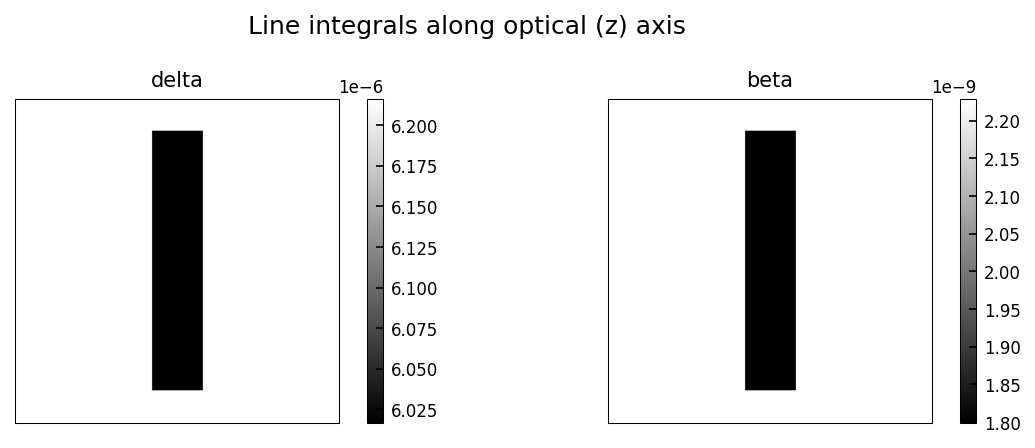

In [6]:

fiber_width = 100e-6
obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy, fiber_material=nylon, background_material=pmma)

show_phantom(obj_delta, obj_beta)

### From aapm2025:

In [7]:
# Variables:
fiber_width_list = [20e-6, 50e-6, 100e-6]  
Nz_list = [10]  

# Nz list was originally [1, 5, 10] but this made 5 and 10 inaccessible,
# per the aforementioned Jax storage error

Image Storage Arrays

**Note of Error** that I can't figure out how to make Jax reliably store the (2D) images into a 2D array. So far, this only works with a functionally 1D array. That is, `storage[i][j]` where each element is an image will only work for each `storage[i][0]`. If `j` is anything except `0`, the image will probably not get stored successfully, and the storage array will remain empty / the way it was initialized. Sometimes the storage assignment does work, though, the bug is nondeterministic as far as I can tell.

In [8]:
# I will crop the fringe off the images ahead of time to minimize runtime.
# The fastest way to reverse this is to set fringe_crop_px = 0.
fringe_crop_px = 4                               # number of pixels to crop off *each* edge of the images
img_height = det_shape[0] - (2*fringe_crop_px)   # "height" as in number of rows
img_width = det_shape[1] - (2*fringe_crop_px)    # "width" as in number of columns
img_shape = (img_height, img_width)

# each array is 4D overall: a 2D array of 2D images
fiber_store_images_approx = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
fiber_store_images_multi = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))


Loop over widths and Nz:

fiber width = 20 micron, Nz = 10
proj approx done - 3.72 s
multislice done - 1.06 s


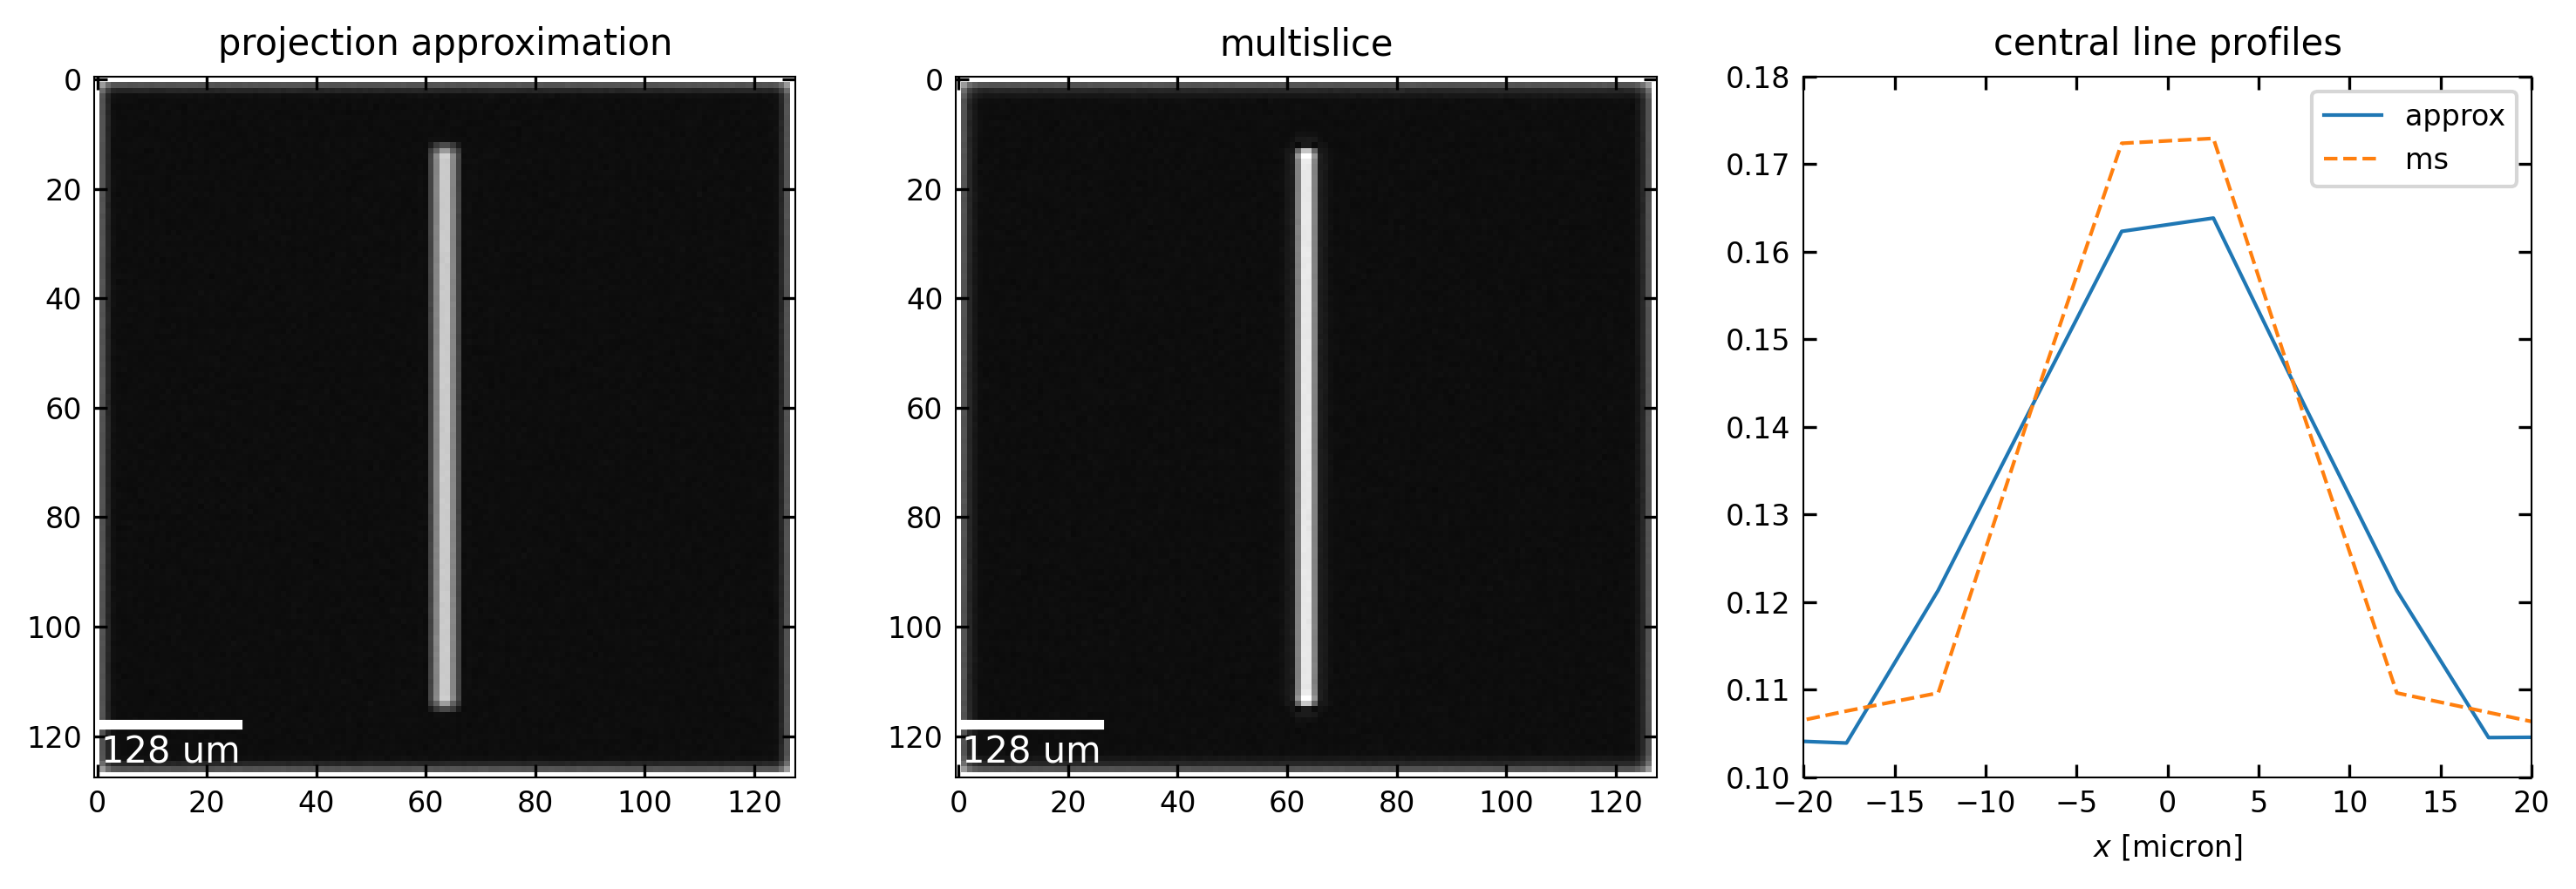

fiber width = 50 micron, Nz = 10
proj approx done - 0.24 s
multislice done - 0.94 s


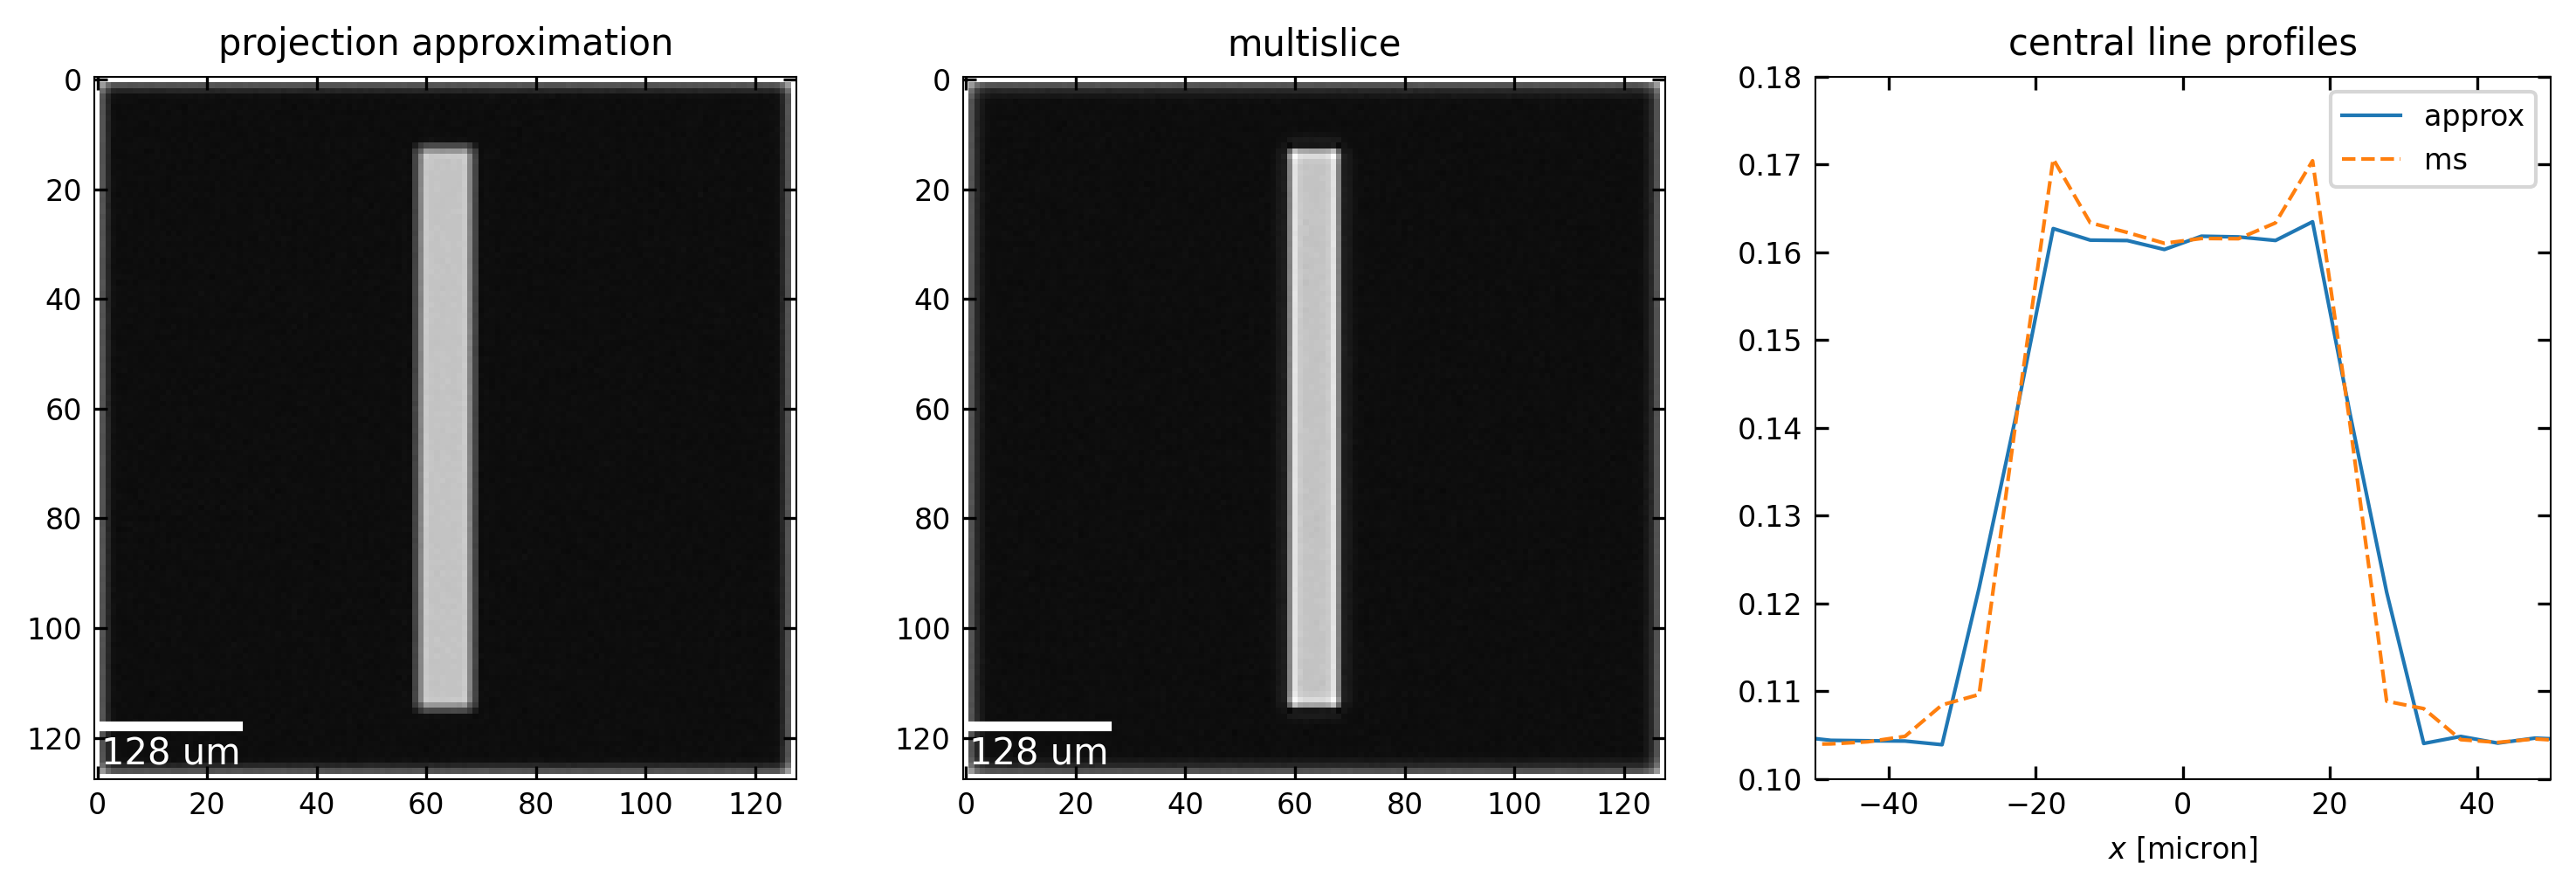

fiber width = 100 micron, Nz = 10
proj approx done - 0.37 s
multislice done - 0.81 s


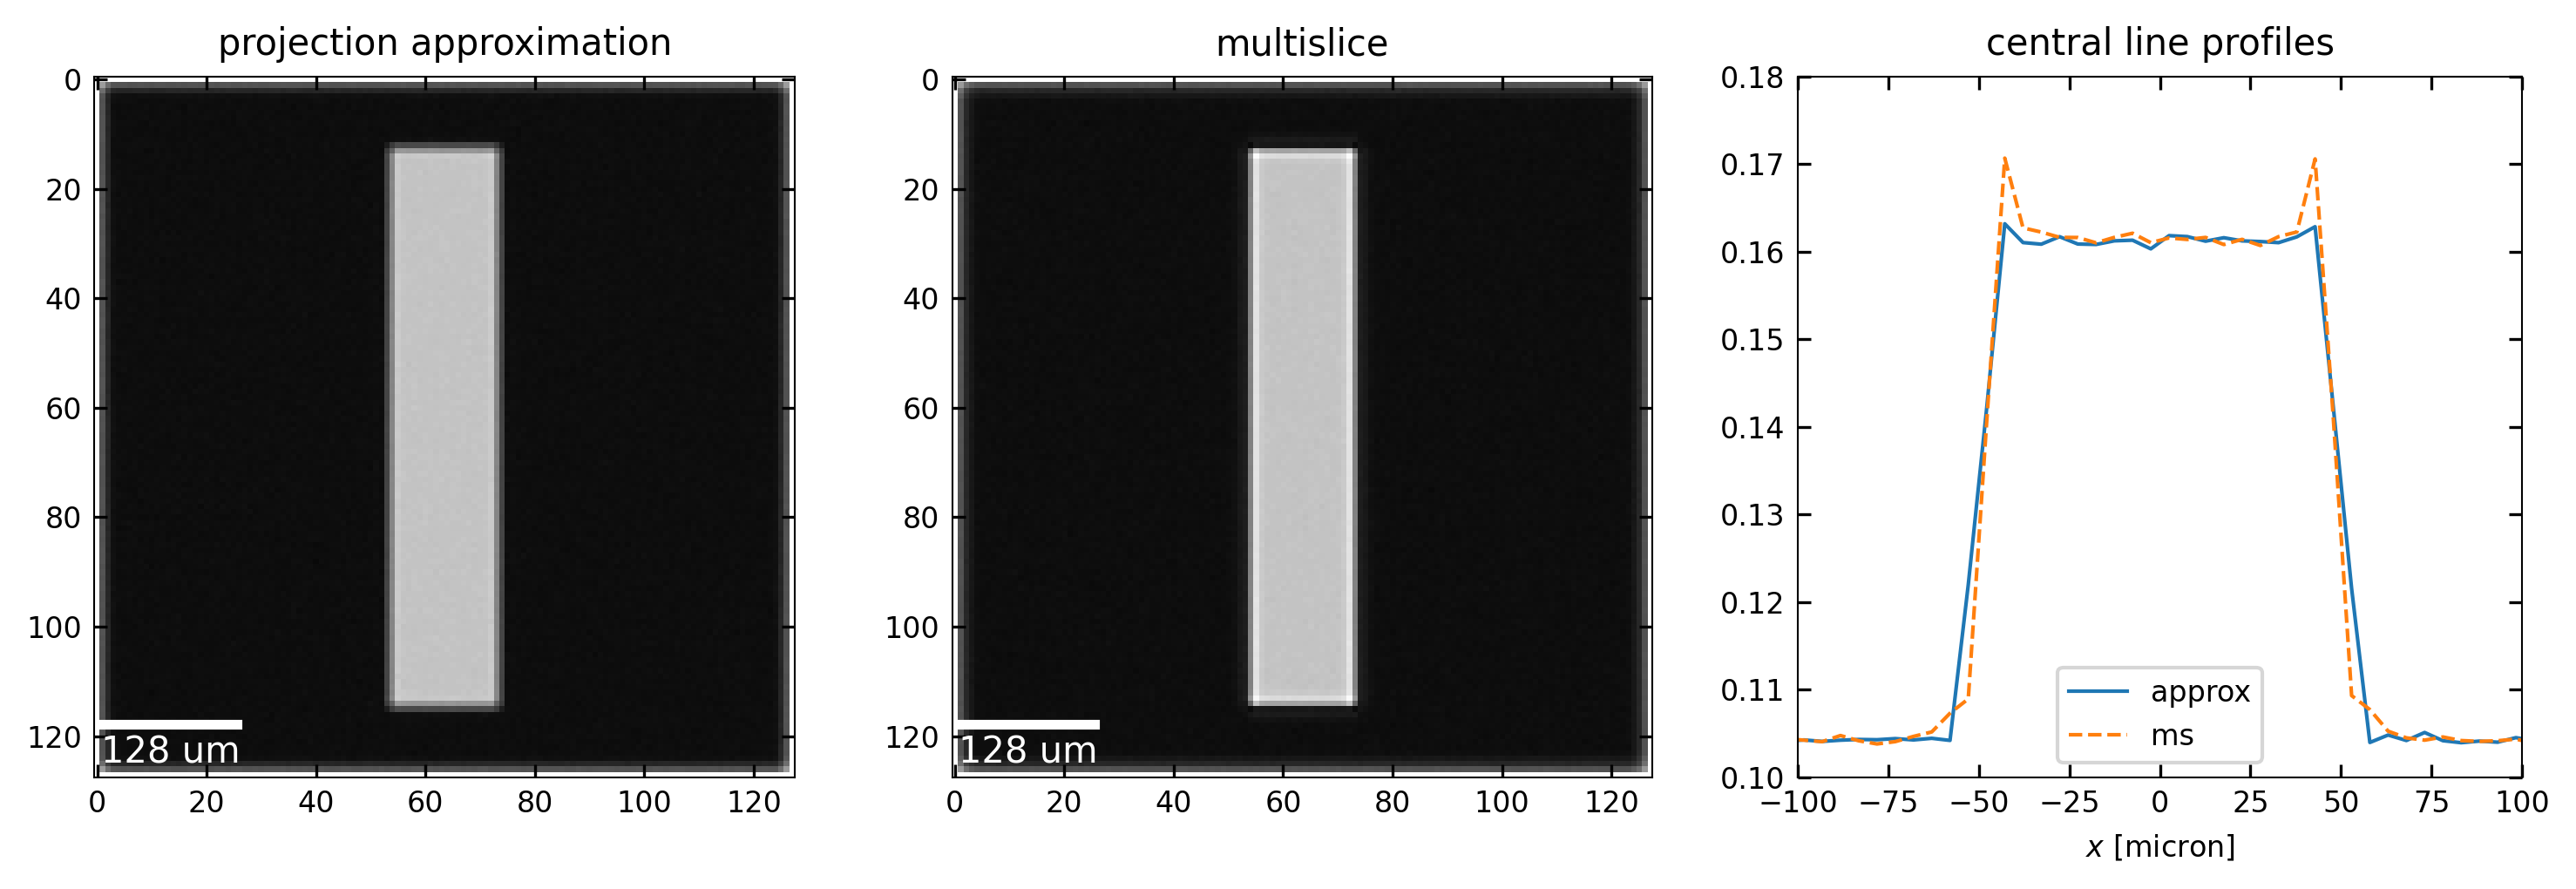

CPU times: user 23.9 s, sys: 3.64 s, total: 27.5 s
Wall time: 18.7 s


In [9]:
%%time

for i, fiber_width in enumerate(fiber_width_list):
    for j, Nz in enumerate(Nz_list):
        print(f'fiber width = {fiber_width*1e6:.0f} micron, Nz = {Nz}')
        
        # Compute dependent parameters & make the phantom.
        dz = thickness/Nz
        phantom_shape = jnp.array([Nz, N, N])
        obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy, fiber_material=nylon, background_material=pmma)

        
        # Simulate with the two methods.
        t0 = time()
        beta_proj = dz * jnp.sum(obj_beta, axis=0)
        delta_proj = dz * jnp.sum(obj_delta, axis=0)
        img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf) 
        print(f'proj approx done - {time() - t0:.2f} s')

        fiber_store_images_approx = fiber_store_images_approx.at[i, j].set(img_approx[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])

        t0 = time()
        img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf)
        print(f'multislice done - {time() - t0:.2f} s')

        fiber_store_images_multi = fiber_store_images_multi.at[i, j].set(img_ms[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])

        
        # View the images.
        # Note - the images have some bright fringes at the edges (artifacts of the simulation). Should we crop these out?
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
        # kw = {'cmap':'gray', 'vmin':im_min(img_approx, img_ms), 'vmax':im_max(img_approx, img_ms)}  # so that the images have the same colorscale
        kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}  # so that the images have the same colorscale

        ax[0].set_title('projection approximation')
        m = ax[0].imshow(img_approx, **kw)
        # fig.colorbar(m, ax=ax[0])

        ax[1].set_title('multislice')
        m = ax[1].imshow(img_ms, **kw)
        # fig.colorbar(m, ax=ax[1])

        for i in range(2):  # for the first two axes...
            add_scalebar(ax[i], 0.2, det_shape[0], det_dx*1e6, 'um', color='w')
            # ax[i].axis('off')  # get rid of the x and y ticks

        ax[2].set_title('central line profiles')
        i_row = int((det_shape[0])/2)  
        x = 1e6 * np.linspace(-det_fov/2, det_fov/2, det_shape[0])
        ax[2].set_xlabel('$x$ [micron]')
        ax[2].set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
        ax[2].set_ylim(kw['vmin'], kw['vmax'])
        ax[2].plot(x, img_approx[i_row], linestyle='-', label='approx')  
        ax[2].plot(x, img_ms[i_row], linestyle='--', label='ms')
        ax[2].legend()

        fig.tight_layout()
        plt.show()

        

### Figure 3, Nylon Fibers Only:

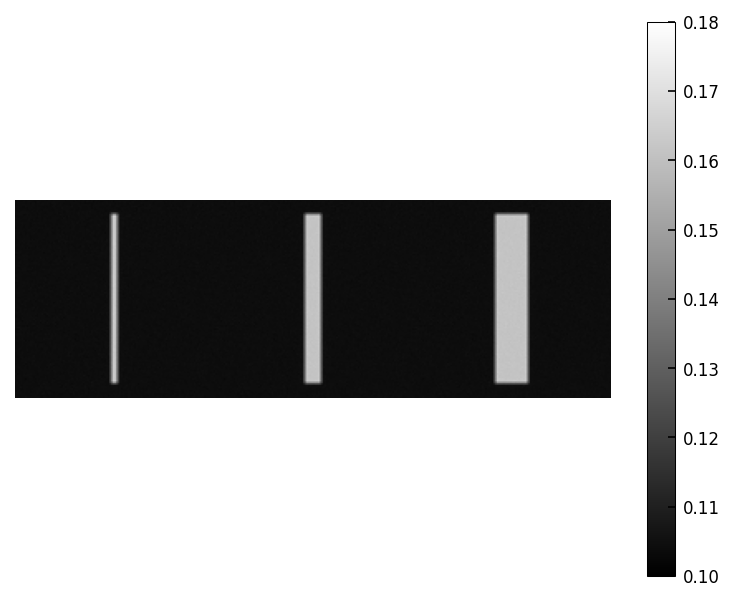

In [10]:
vmin = 0.1
vmax = 0.18

approx_mosaic_fibers = np.hstack((fiber_store_images_approx[0][0], fiber_store_images_approx[1][0], fiber_store_images_approx[2][0]))

plt.imshow(approx_mosaic_fibers, cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.colorbar()
plt.show()

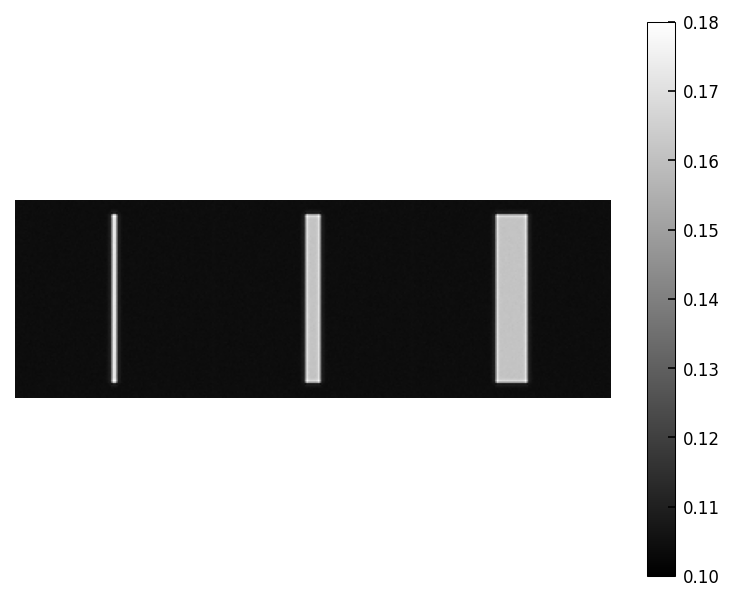

In [11]:
multi_mosaic_fibers = np.hstack((fiber_store_images_multi[0][0], fiber_store_images_multi[1][0], fiber_store_images_multi[2][0]))

plt.imshow(multi_mosaic_fibers, cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.colorbar()
plt.show()

## Glass specks
Cylindrical inserts.

### Glass Cylinder Phantom

In [12]:
def make_speck_phantom(N, Nz, dx, speck_radius, energy, speck_material=glass, background_material=pmma):

    fov = N*dx
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)
    speck_shift = 0.25*fov               # Cailey changed this by hand from 0.15*fov
    assert speck_shift > speck_radius
    
    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(Nz):
        for xc in [-speck_shift, speck_shift]:
            for yc in [-speck_shift, speck_shift]:
                mask = np.where(((X-xc)**2 + (Y-yc)**2 < speck_radius**2))  
                obj[z][mask] = 1
                # adjust to decrease in thickness

    matdict = {0: background_material, 1: speck_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta




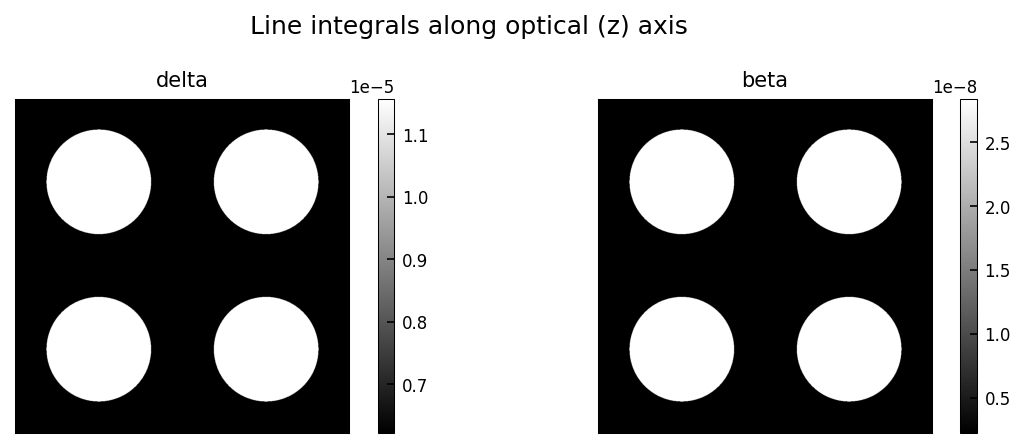

CPU times: user 4.26 s, sys: 793 ms, total: 5.05 s
Wall time: 3.82 s


In [13]:
%%time

if glass_cylinders:
    speck_radius = 100e-6
    obj_delta, obj_beta = make_speck_phantom(N, Nz, dx, speck_radius, energy)

    show_phantom(obj_delta, obj_beta)

### Glass Cylinder Functional Run

In [58]:
# I had to change these to actually see the specks without squinting

vmin = 0.09
vmax = 0.14

speck radius = 20 micron, Nz = 10
proj approx done - 0.13 s
multislice done - 0.72 s


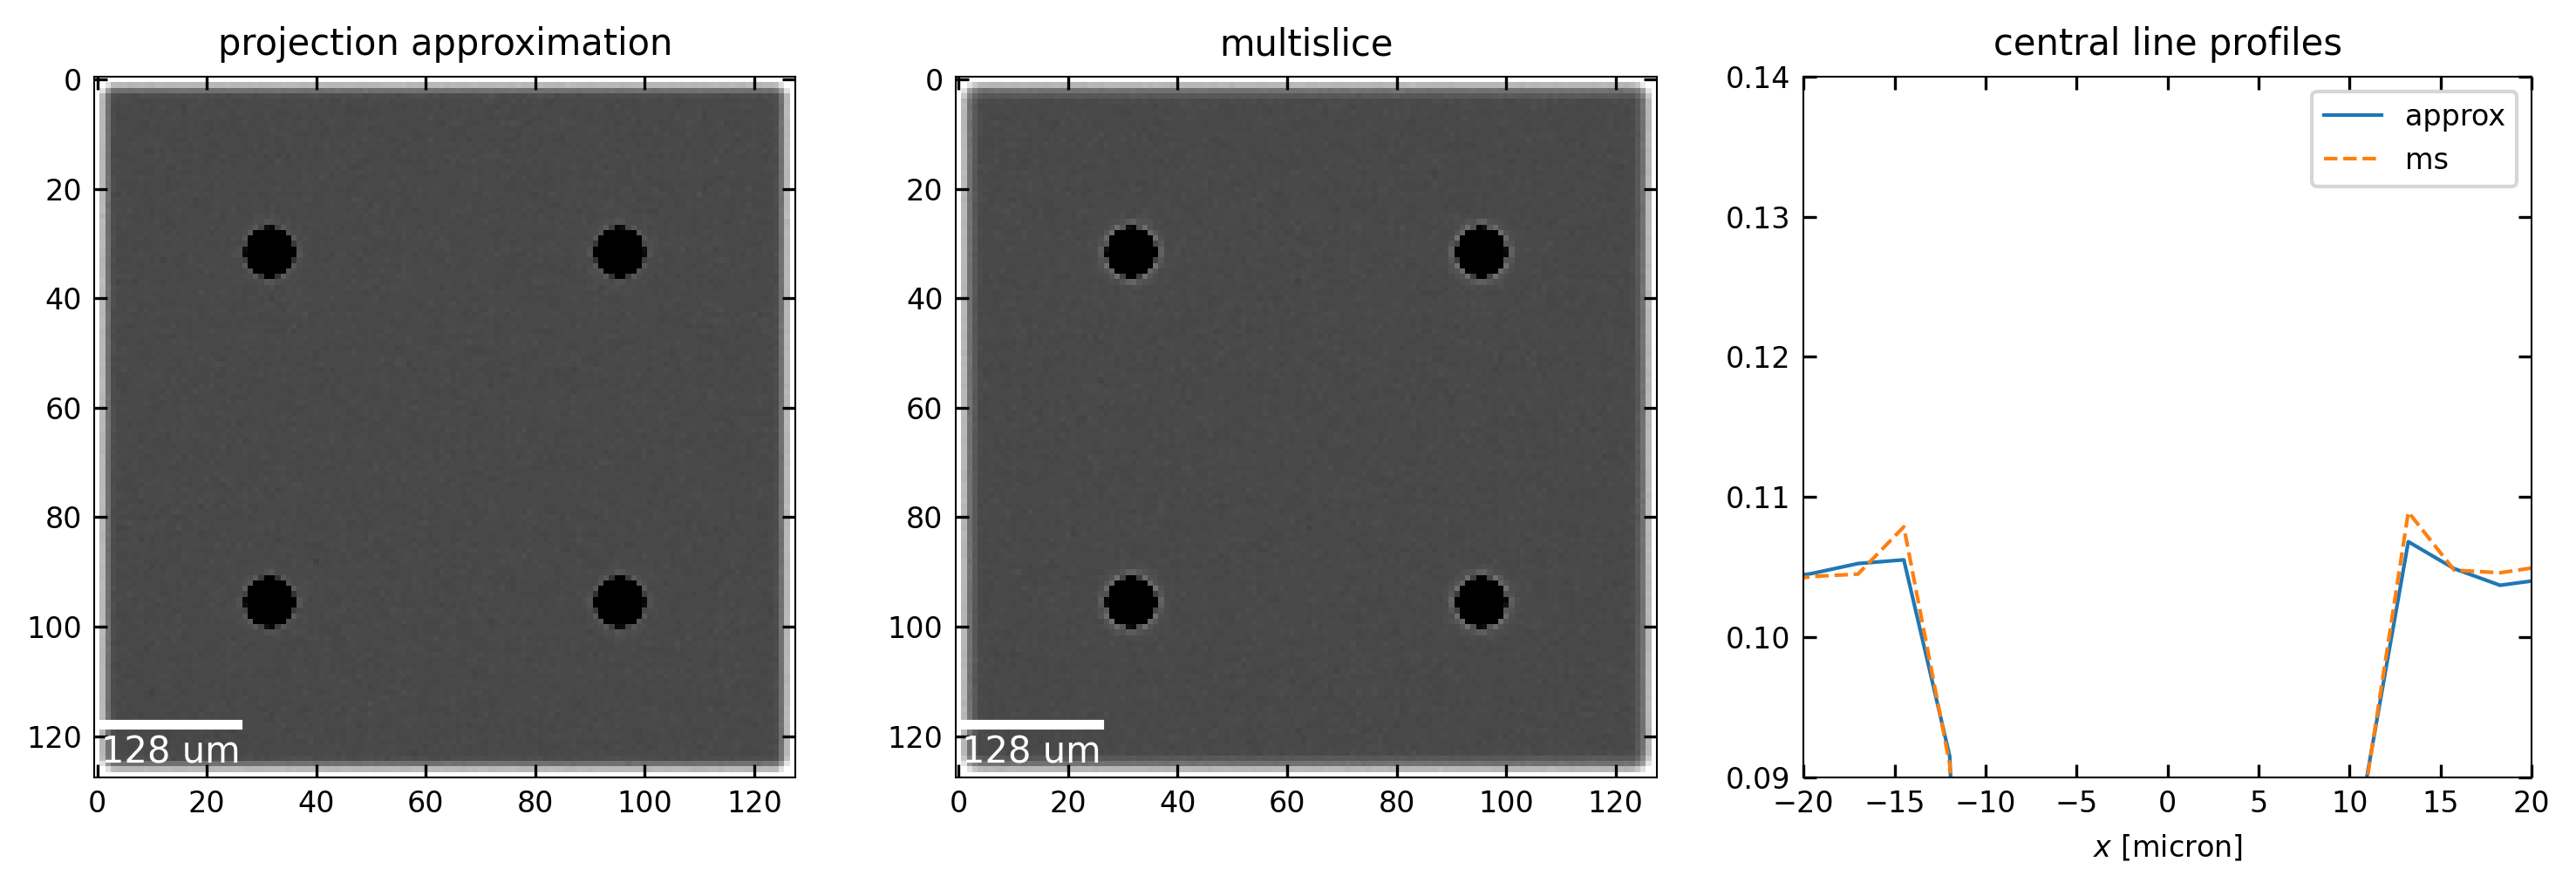

speck radius = 50 micron, Nz = 10
proj approx done - 0.26 s
multislice done - 0.75 s


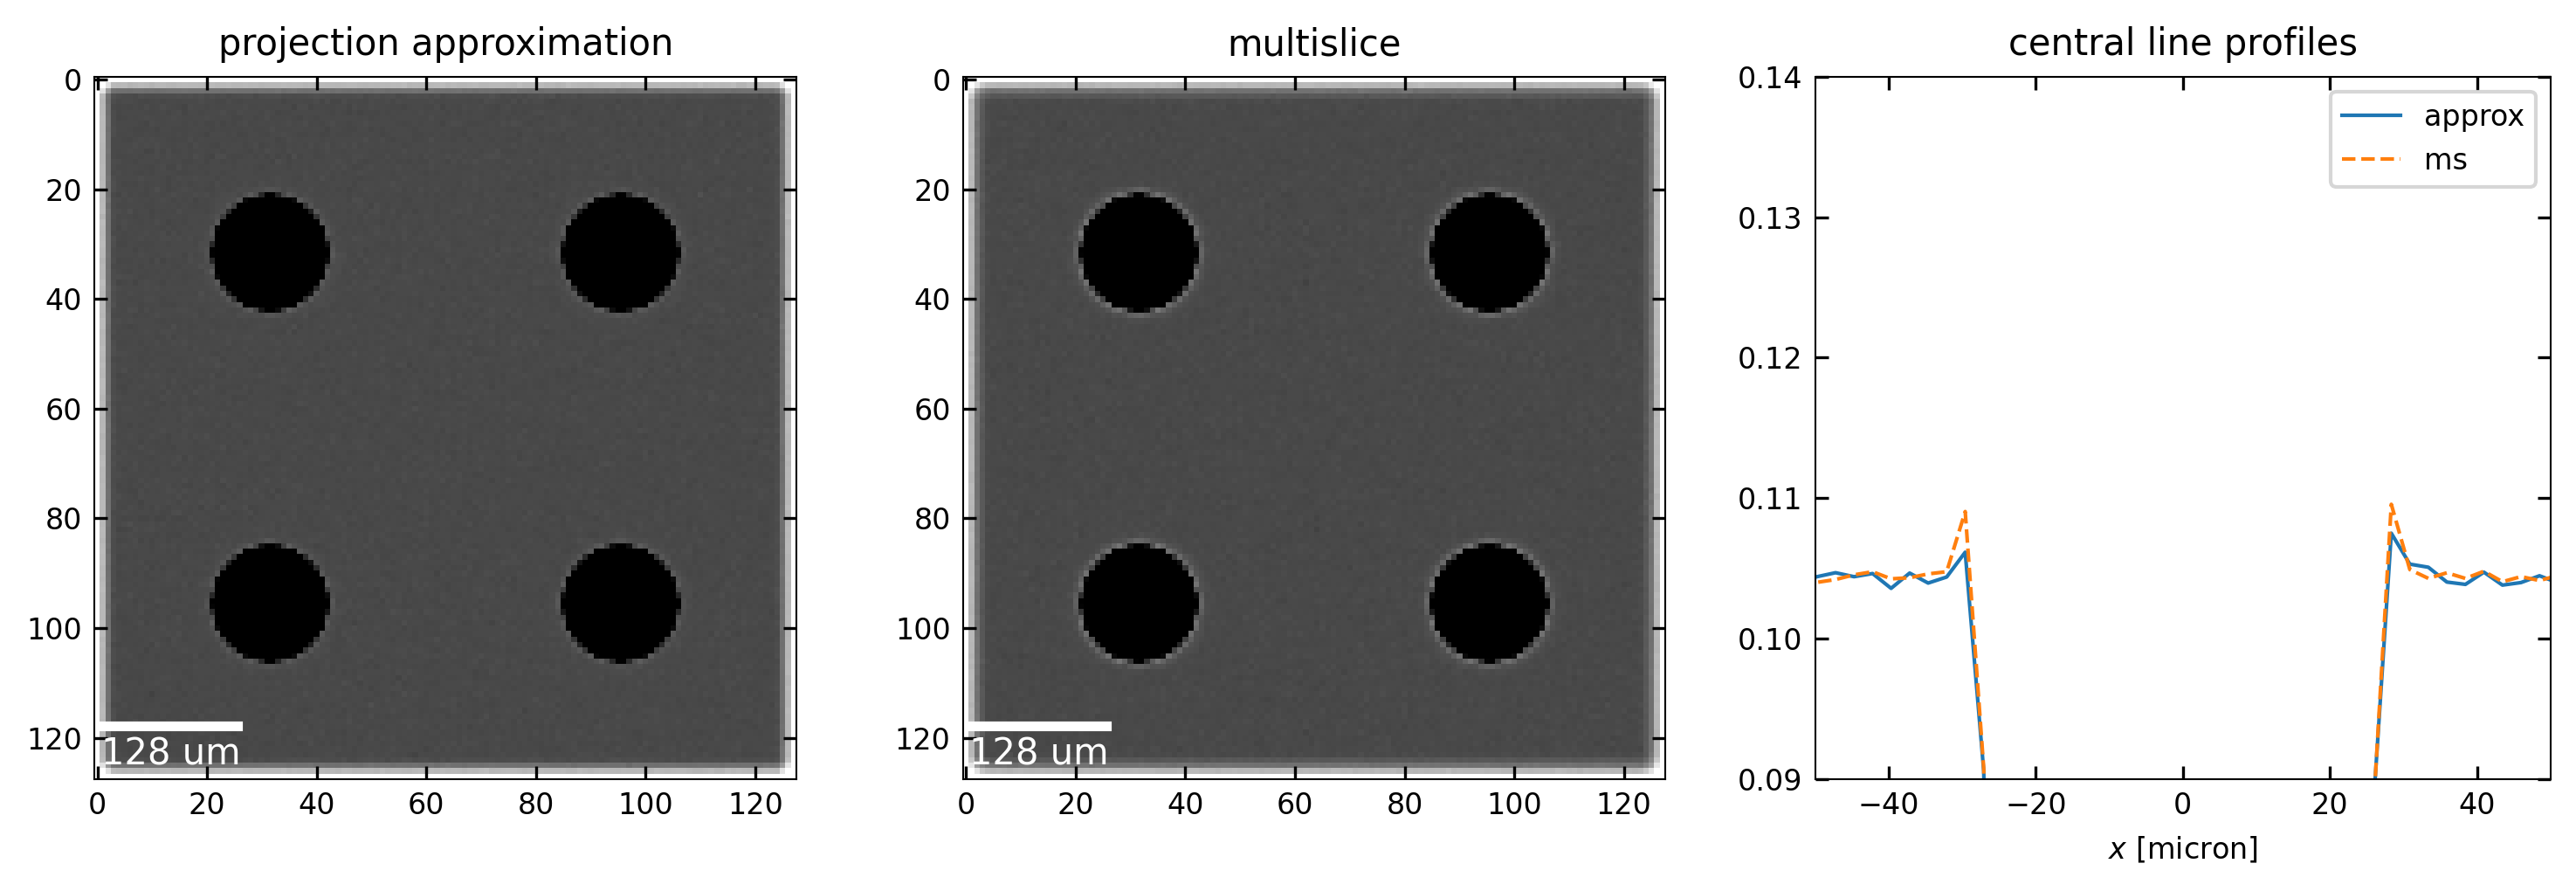

speck radius = 100 micron, Nz = 10
proj approx done - 0.64 s
multislice done - 0.75 s


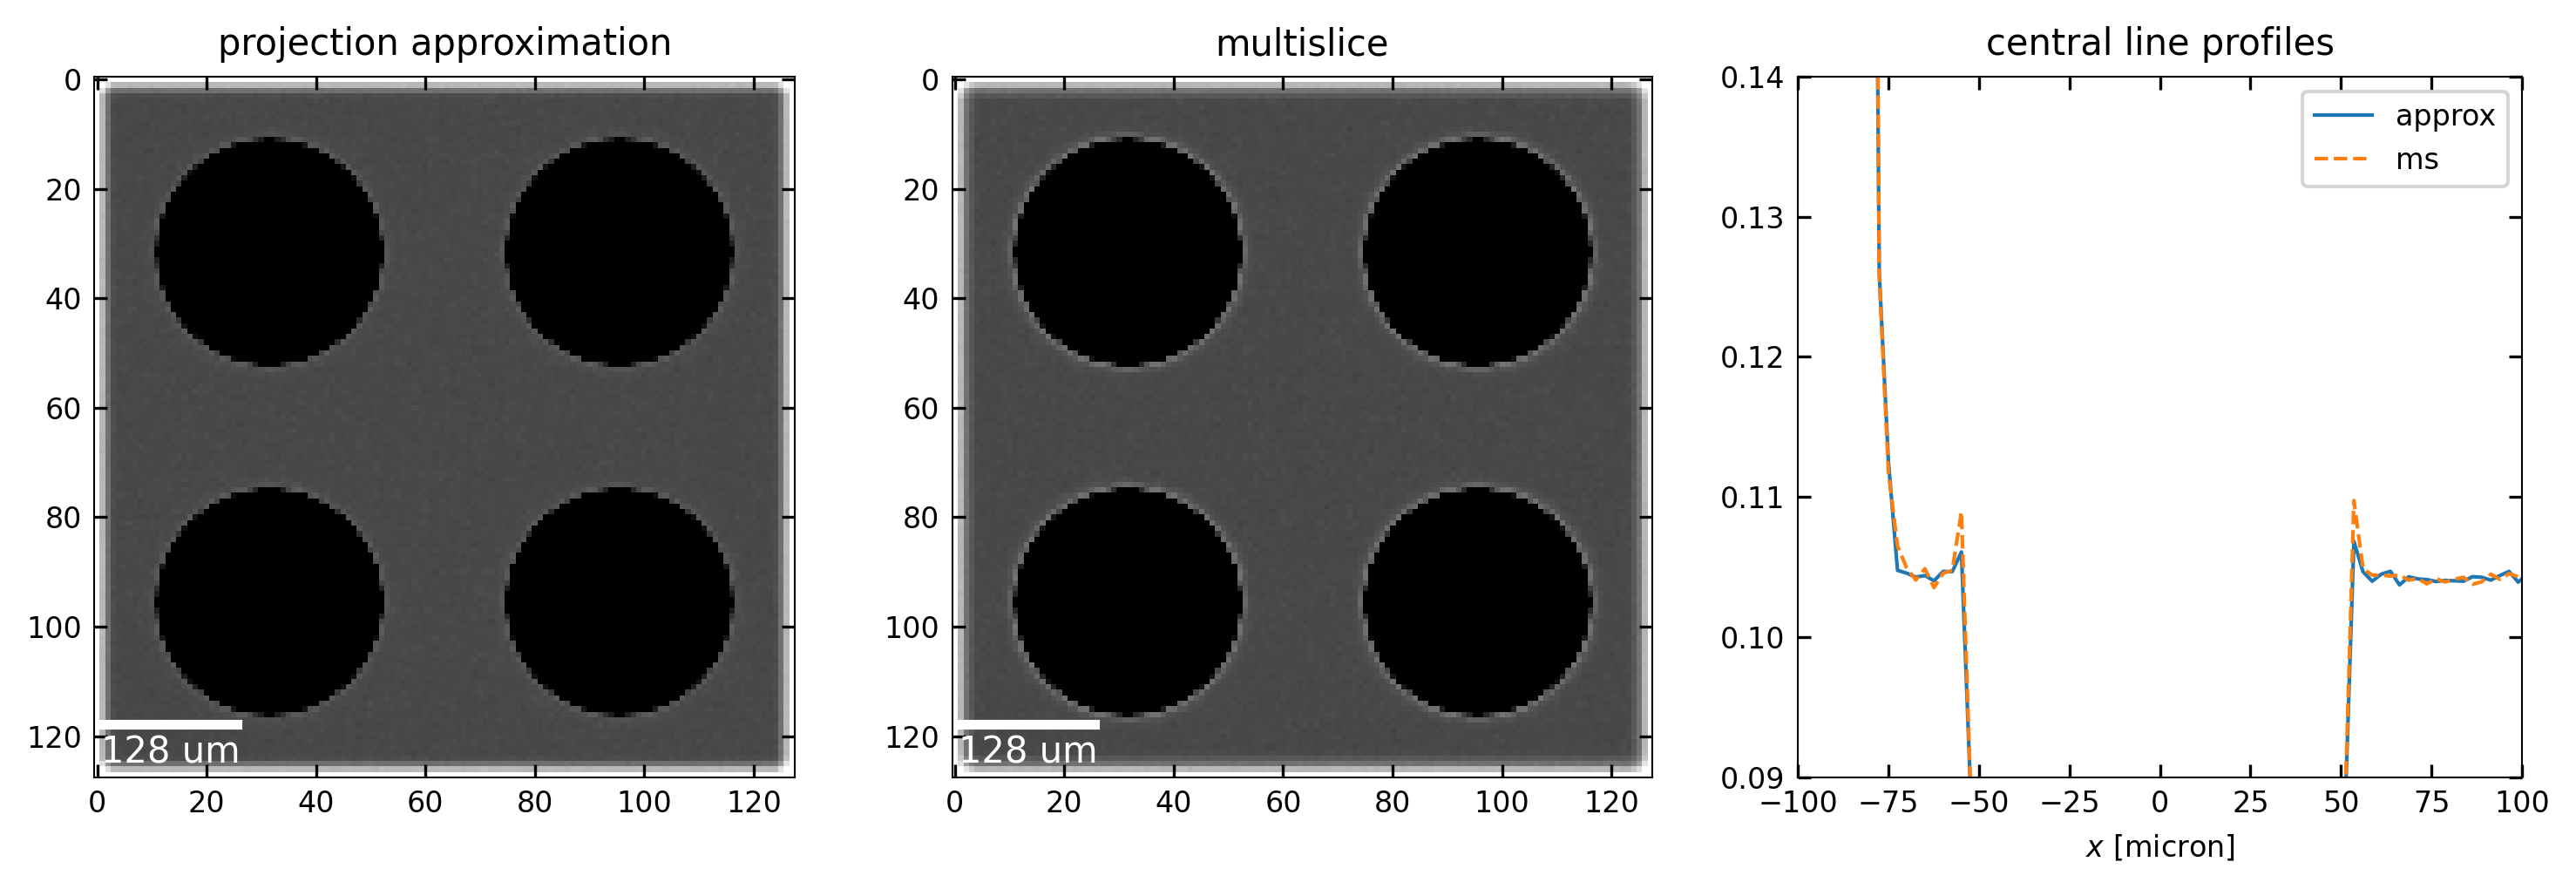

CPU times: user 15 s, sys: 1.87 s, total: 16.9 s
Wall time: 11.1 s


In [59]:
%%time

if glass_cylinders:
    # reset the storage arrays
    cylinder_store_images_approx = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
    cylinder_store_images_multi = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))

    # Note for convenience I am using the fiber widths as radii now
    for i, speck_radius in enumerate(fiber_width_list):
        for j, Nz in enumerate(Nz_list):
            print(f'speck radius = {speck_radius*1e6:.0f} micron, Nz = {Nz}')
            
            # Compute dependent parameters & make the phantom.
            dz = thickness/Nz
            phantom_shape = jnp.array([Nz, N, N])
            obj_delta, obj_beta = make_speck_phantom(N, Nz, dx, speck_radius, energy, speck_material=glass, background_material=pmma)
            
            # Simulate with the two methods.
            t0 = time()
            beta_proj = dz * jnp.sum(obj_beta, axis=0)
            delta_proj = dz * jnp.sum(obj_delta, axis=0)
            img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf) 
            print(f'proj approx done - {time() - t0:.2f} s')

            cylinder_store_images_approx = cylinder_store_images_approx.at[i, j].set(img_approx[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])

            t0 = time()
            img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf)
            print(f'multislice done - {time() - t0:.2f} s')

            cylinder_store_images_multi = cylinder_store_images_multi.at[i, j].set(img_ms[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])

            
            # View the images.
            # Note - the images have some bright fringes at the edges (artifacts of the simulation). Should we crop these out?
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
            # kw = {'cmap':'gray', 'vmin':im_min(img_approx, img_ms), 'vmax':im_max(img_approx, img_ms)}  # so that the images have the same colorscale
            kw = {'cmap':'gray', 'vmin':vmin, 'vmax':vmax}  # so that the images have the same colorscale

            ax[0].set_title('projection approximation')
            m = ax[0].imshow(img_approx, **kw)
            # fig.colorbar(m, ax=ax[0])

            ax[1].set_title('multislice')
            m = ax[1].imshow(img_ms, **kw)
            # fig.colorbar(m, ax=ax[1])

            for i in range(2):  # for the first two axes...
                add_scalebar(ax[i], 0.2, det_shape[0], det_dx*1e6, 'um', color='w')
                # ax[i].axis('off')  # get rid of the x and y ticks

            ax[2].set_title('central line profiles')
            i_row = int((det_shape[0])/4)  
            # x = 1e6 * np.linspace(-det_fov/2, det_fov/2, det_shape[0])
            x = 1e6 * np.linspace(-det_fov/8, 3*det_fov/8, det_shape[0])
            ax[2].set_xlabel('$x$ [micron]')
            ax[2].set_xlim(-speck_radius*1e6, speck_radius*1e6)  # zoom into the speck_radius
            ax[2].set_ylim(kw['vmin'], kw['vmax'])
            ax[2].plot(x, img_approx[i_row], linestyle='-', label='approx')  
            ax[2].plot(x, img_ms[i_row], linestyle='--', label='ms')
            ax[2].legend()

            fig.tight_layout()
            plt.show()



### Figure 3, Glass Specks Only

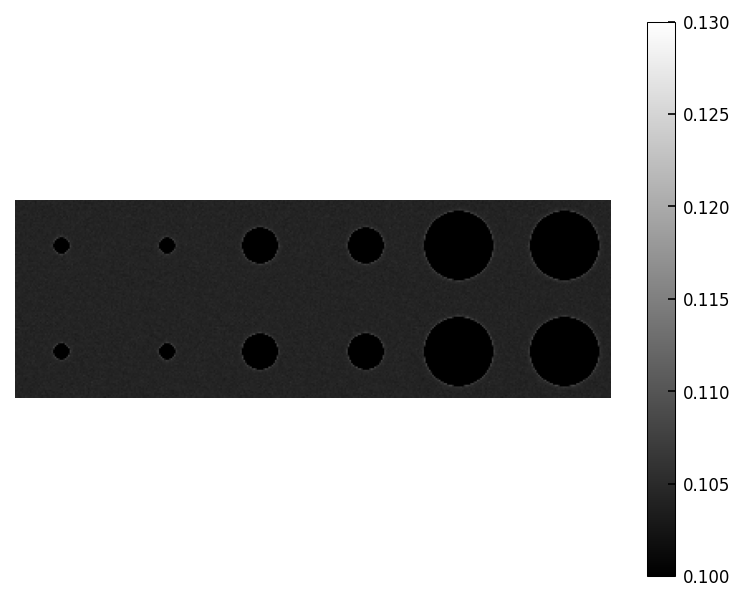

In [32]:
if glass_cylinders:

    approx_mosaic_cylinders = np.hstack((cylinder_store_images_approx[0][0], cylinder_store_images_approx[1][0], cylinder_store_images_approx[2][0]))

    plt.imshow(approx_mosaic_cylinders, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.colorbar()
    plt.show()

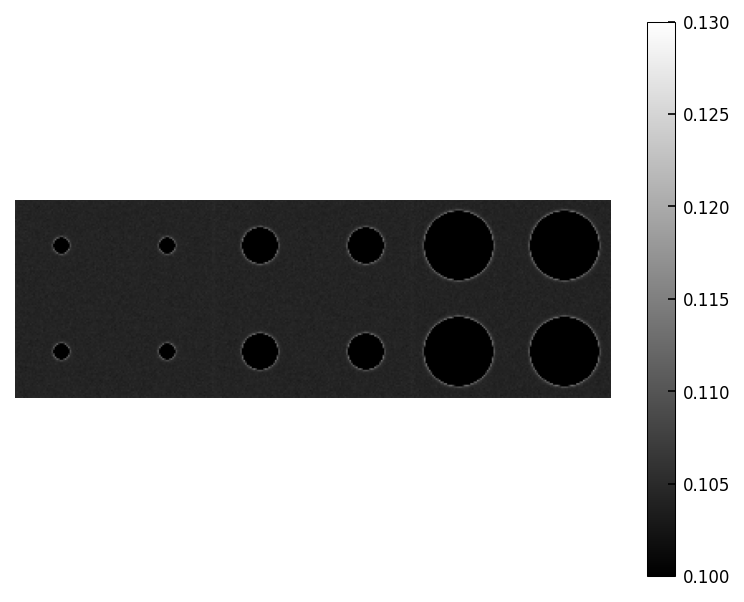

In [33]:
if glass_cylinders:
    multi_mosaic_cylinders = np.hstack((cylinder_store_images_multi[0][0], cylinder_store_images_multi[1][0], cylinder_store_images_multi[2][0]))

    plt.imshow(multi_mosaic_cylinders, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.colorbar()
    plt.show()

## Spherical tissue inserts
Single spheres of breast or adipose tissue.

### Tissue Sphere Phantom

In [35]:
%%time

def make_sphere_phantom(N, Nz, dx, radius, energy, sphere_material=breast, background_material=pmma):

    fov = N*dx
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    zcoords = np.abs(np.linspace(-fov/2, fov/2, Nz))
    # field of view should shrink
    # accidentally shrinks sphere, sphere is too large
    Z, X, Y = np.meshgrid(zcoords, coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    mask = np.where((X**2 + Y**2 + Z**2 < sphere_radius**2)) 
    mask = (mask[1], mask[0], mask[2])  # ? works
    
    obj[mask] = 1

    matdict = {0: background_material, 1: sphere_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta




CPU times: user 9 μs, sys: 1 μs, total: 10 μs
Wall time: 13.6 μs


In [36]:
%%time

if tissue_spheres:
    sphere_radius = 200e-6
    obj_delta, obj_beta = make_sphere_phantom(N, 100, dx, sphere_radius, energy)  # need larger Nz to resolve sphere curve

    show_phantom(obj_delta, obj_beta)

CPU times: user 5 μs, sys: 1e+03 ns, total: 6 μs
Wall time: 10.3 μs


### Tissue Sphere Functional Run

In [19]:
%%time

if tissue_spheres:
    # reset the storage arrays
    sphere_store_images_approx = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
    sphere_store_images_multi = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))

    # Note that, like last time, I am using the same list for radii
    for i, radius in enumerate(fiber_width_list):
        for j, Nz in enumerate(Nz_list):
            print(f'radius = {radius*1e6:.0f} micron, Nz = {Nz}')
            
            # Compute dependent parameters & make the phantom.
            dz = thickness/Nz
            phantom_shape = jnp.array([Nz, N, N])
            obj_delta, obj_beta = make_sphere_phantom(N, Nz, dx, radius, energy, sphere_material=breast, background_material=pmma)

            
            # Simulate with the two methods.
            t0 = time()
            beta_proj = dz * jnp.sum(obj_beta, axis=0)
            delta_proj = dz * jnp.sum(obj_delta, axis=0)
            img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf) 
            print(f'proj approx done - {time() - t0:.2f} s')

            sphere_store_images_approx = sphere_store_images_approx.at[i, j].set(img_approx[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])

            t0 = time()
            img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf)
            print(f'multislice done - {time() - t0:.2f} s')

            sphere_store_images_multi = sphere_store_images_multi.at[i, j].set(img_ms[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])

            
            # View the images.
            # Note - the images have some bright fringes at the edges (artifacts of the simulation). Should we crop these out?
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
            # kw = {'cmap':'gray', 'vmin':im_min(img_approx, img_ms), 'vmax':im_max(img_approx, img_ms)}  # so that the images have the same colorscale
            kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}  # so that the images have the same colorscale

            ax[0].set_title('projection approximation')
            m = ax[0].imshow(img_approx, **kw)
            # fig.colorbar(m, ax=ax[0])

            ax[1].set_title('multislice')
            m = ax[1].imshow(img_ms, **kw)
            # fig.colorbar(m, ax=ax[1])

            for i in range(2):  # for the first two axes...
                add_scalebar(ax[i], 0.2, det_shape[0], det_dx*1e6, 'um', color='w')
                # ax[i].axis('off')  # get rid of the x and y ticks

            ax[2].set_title('central line profiles')
            i_row = int((det_shape[0])/2)  
            x = 1e6 * np.linspace(-det_fov/2, det_fov/2, det_shape[0])
            ax[2].set_xlabel('$x$ [micron]')
            ax[2].set_xlim(-radius*1e6, radius*1e6)  # zoom into the fiber width
            ax[2].set_ylim(kw['vmin'], kw['vmax'])
            ax[2].plot(x, img_approx[i_row], linestyle='-', label='approx')  
            ax[2].plot(x, img_ms[i_row], linestyle='--', label='ms')
            ax[2].legend()

            fig.tight_layout()
            plt.show()



CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 10.3 μs


### Figure 3 Tissue Spheres Only

In [20]:
if tissue_spheres:
    vmin = 0.1
    vmax = 0.18

    approx_mosaic_spheres = np.hstack((sphere_store_images_approx[0][0], sphere_store_images_approx[1][0], sphere_store_images_approx[2][0]))

    plt.imshow(approx_mosaic_spheres, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [21]:
if tissue_spheres:
    multi_mosaic_spheres = np.hstack((sphere_store_images_multi[0][0], sphere_store_images_multi[1][0], sphere_store_images_multi[2][0]))

    plt.imshow(multi_mosaic_spheres, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Figure 3

putting it all together

In [22]:
if (nylon_fibers & glass_cylinders & tissue_spheres):
    approx_mosaic_all = np.vstack((approx_mosaic_fibers, approx_mosaic_cylinders, approx_mosaic_spheres))

    plt.imshow(approx_mosaic_all, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [23]:
if (nylon_fibers & glass_cylinders & tissue_spheres):
    multi_mosaic_all = np.vstack((multi_mosaic_fibers, multi_mosaic_cylinders, multi_mosaic_spheres))

    plt.imshow(multi_mosaic_all, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [24]:
if (nylon_fibers & glass_cylinders & tissue_spheres):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,3.5], dpi=300)

    kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}

    ax[0].set_title('projection approximation')
    m = ax[0].imshow(approx_mosaic_all, **kw)
    add_scalebar(ax[0], 0.2, det_shape[0], det_dx*1e6, 'um', color='w')
    fig.colorbar(m, ax=ax[0])
    ax[0].axis('off')

    ax[1].set_title('multislice')
    m = ax[1].imshow(multi_mosaic_all, **kw)
    add_scalebar(ax[1], 0.2, det_shape[0], det_dx*1e6, 'um', color='w')
    fig.colorbar(m, ax=ax[1])
    ax[1].axis('off')

    plt.show()


# Figure 4

### Fiber Line Profiles

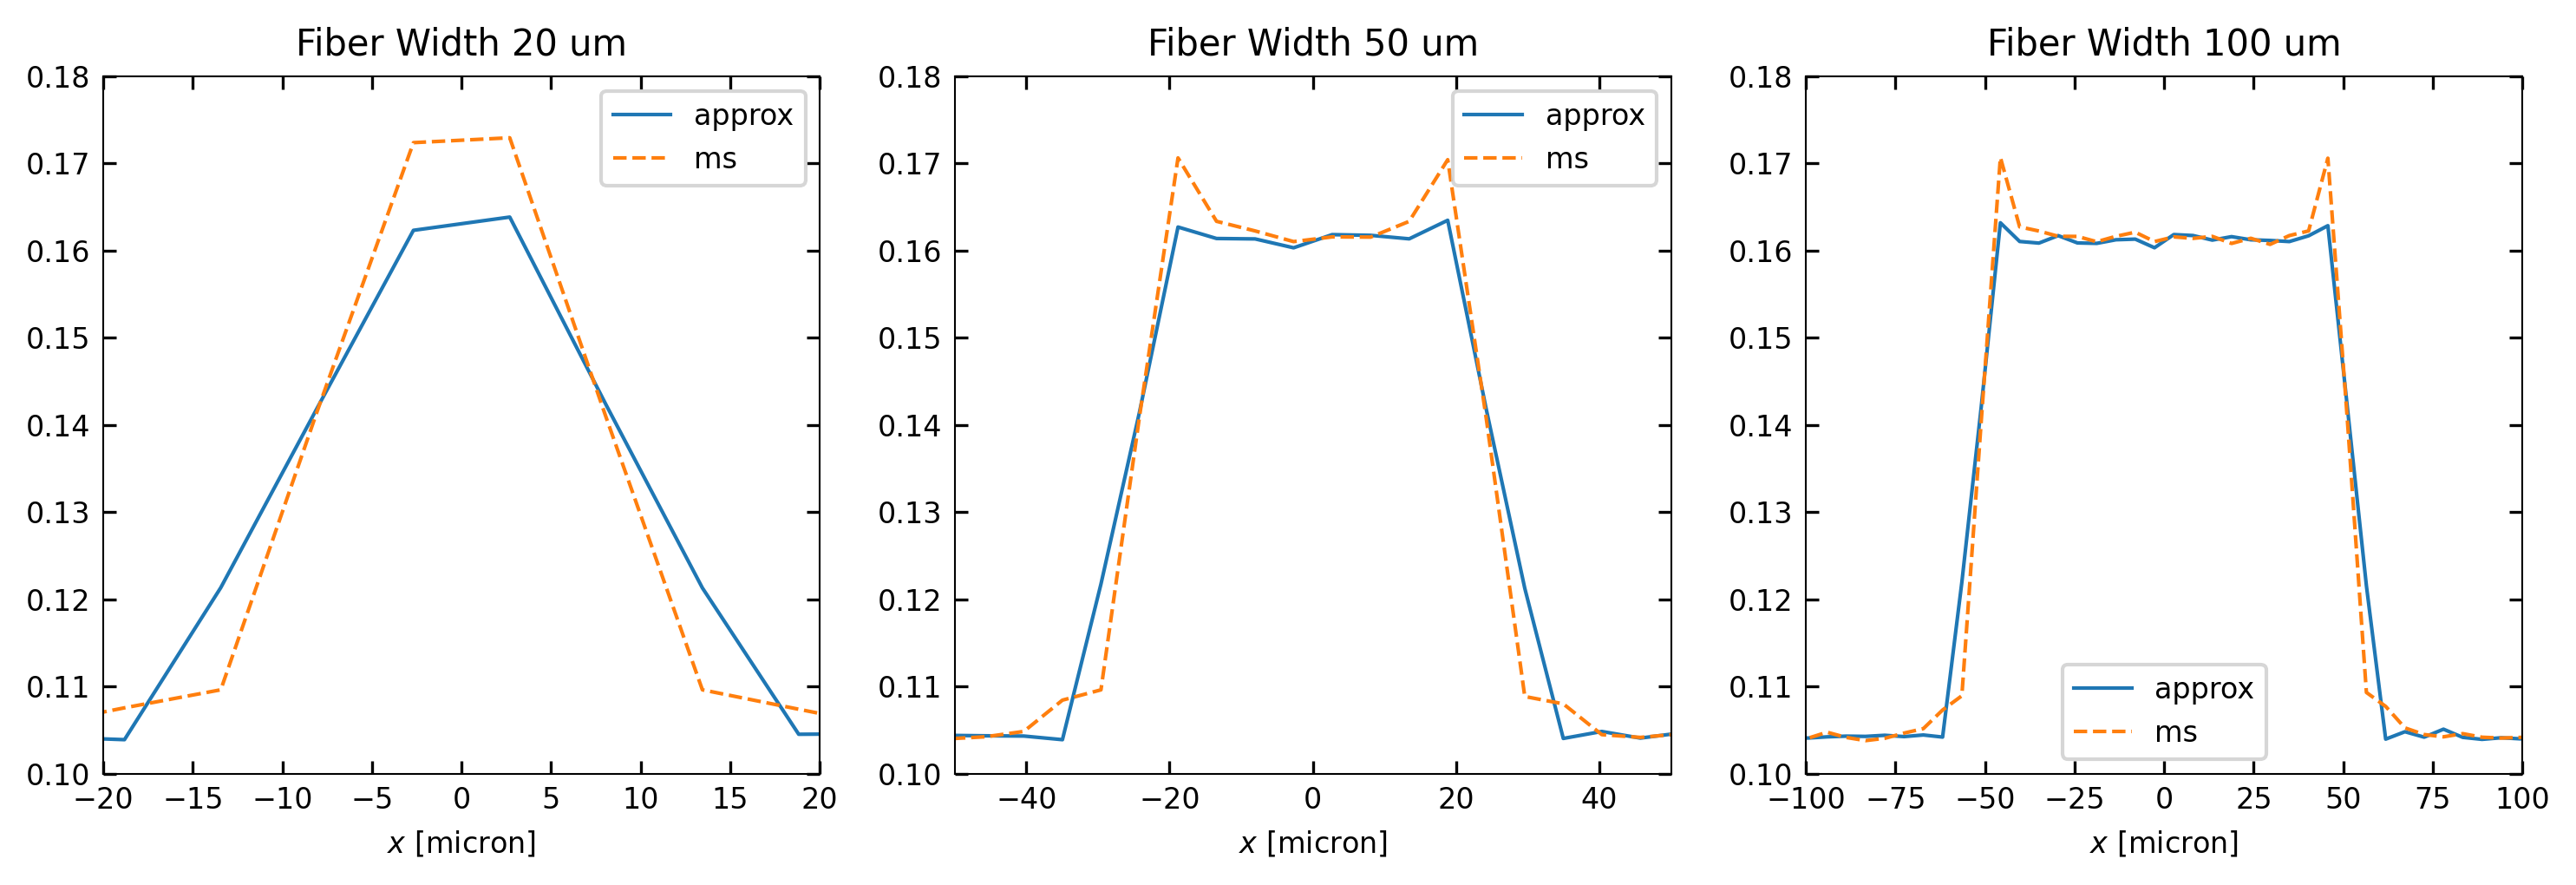

In [41]:
num_rows = det_shape[0] - 2*fringe_crop_px

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}

for i, fiber_width in enumerate(fiber_width_list):
    ax[i].set_title(f'Fiber Width {fiber_width*1e6:.0f} um')
    i_row = int(num_rows/2)  
    x = 1e6 * np.linspace(-det_fov/2, det_fov/2, num_rows)
    ax[i].set_xlabel('$x$ [micron]')
    ax[i].set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
    ax[i].set_ylim(kw['vmin'], kw['vmax'])
    ax[i].plot(x, fiber_store_images_approx[i][0][i_row], linestyle='-', label='approx')  
    ax[i].plot(x, fiber_store_images_multi[i][0][i_row], linestyle='--', label='ms')
    ax[i].legend()

fig.tight_layout()
plt.show()

### Glass Speck Line Profiles

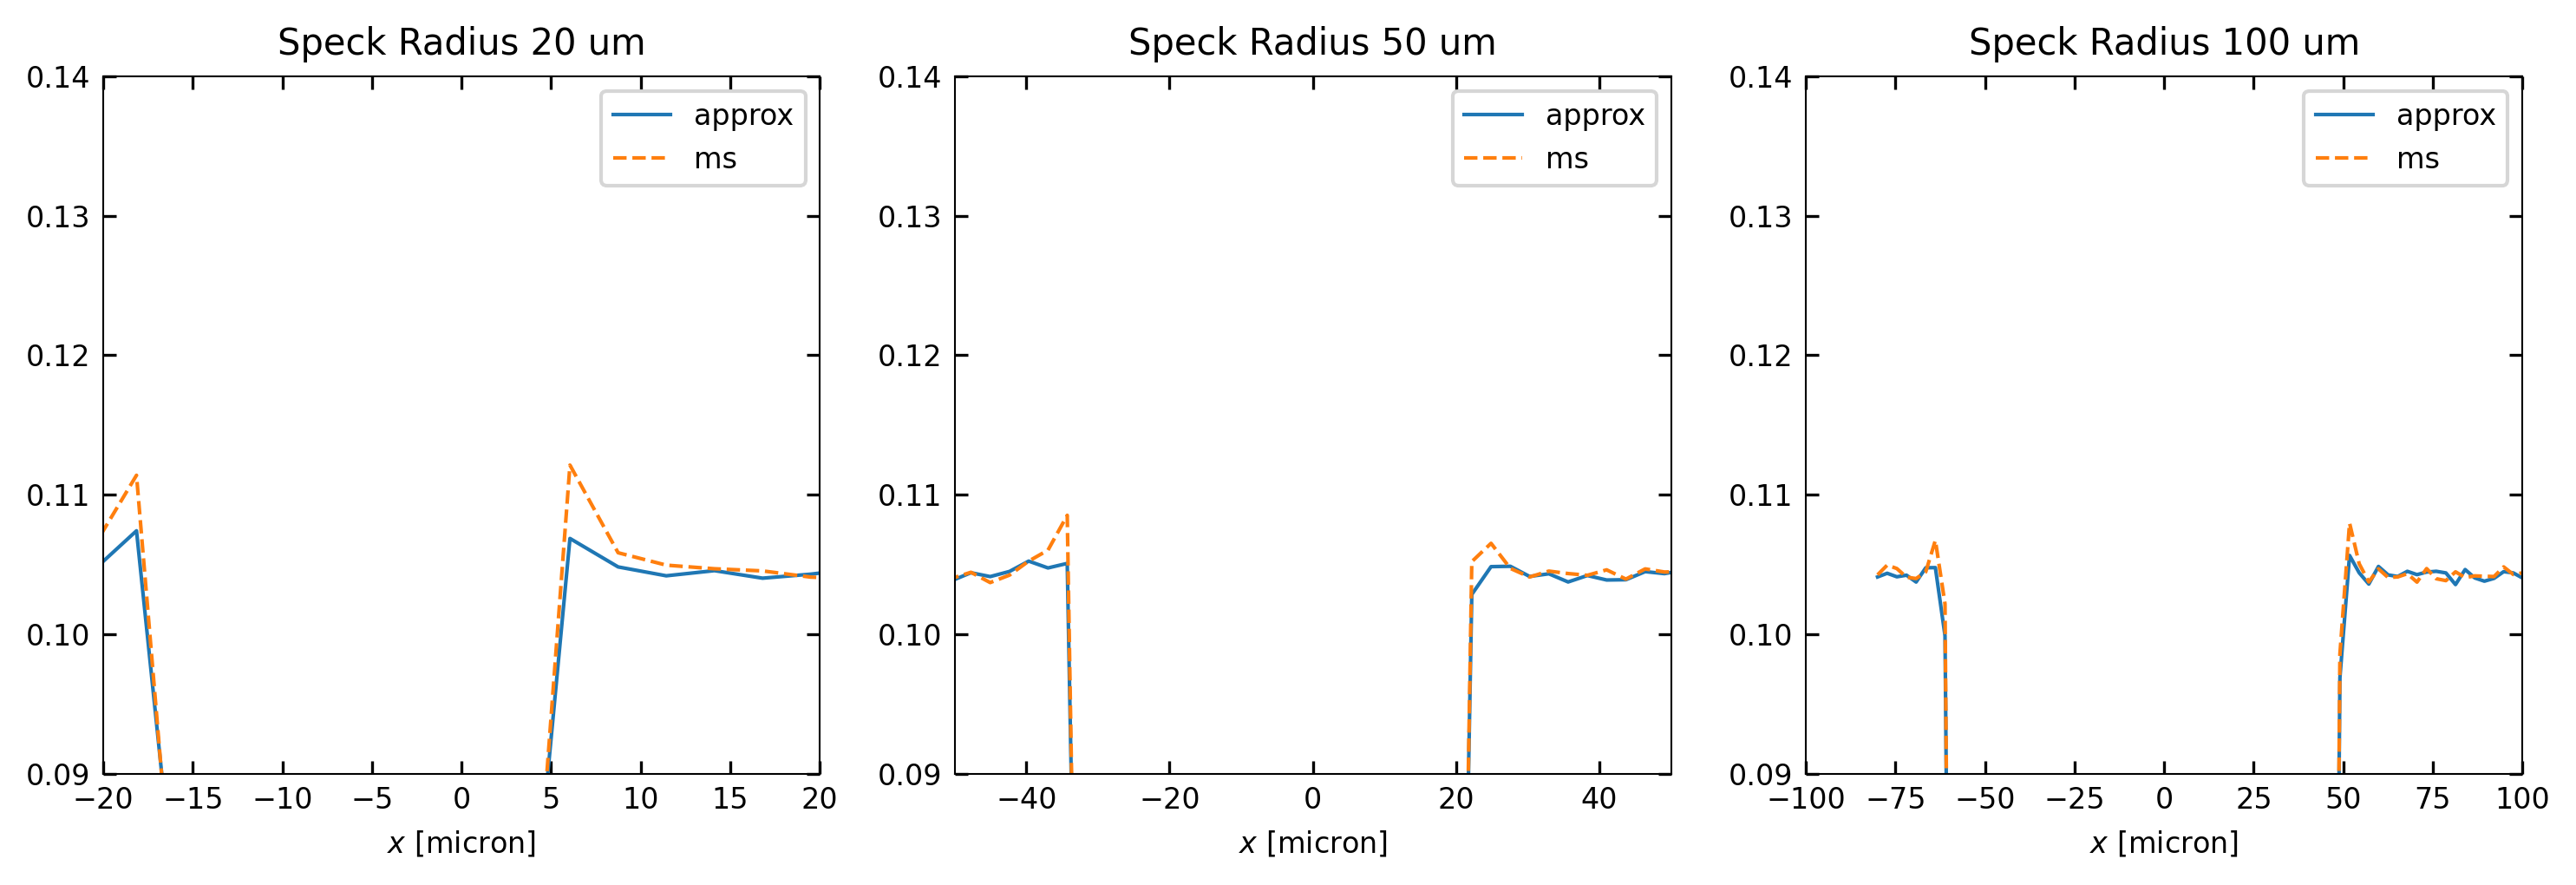

In [62]:
if glass_cylinders:
    num_rows = det_shape[0] - 2*fringe_crop_px

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
    kw = {'cmap':'gray', 'vmin':0.09, 'vmax':0.14}

    for i, speck_radius in enumerate(fiber_width_list):
        ax[i].set_title(f'Speck Radius {speck_radius*1e6:.0f} um')
        i_row = int(num_rows/4)  
        x = 1e6 * np.linspace(-det_fov/8, 3*det_fov/8, num_rows)
        ax[i].set_xlabel('$x$ [micron]')
        ax[i].set_xlim(-speck_radius*1e6, speck_radius*1e6)  # zoom into the speck_radius
        ax[i].set_ylim(kw['vmin'], kw['vmax'])
        ax[i].plot(x, cylinder_store_images_approx[i][0][i_row], linestyle='-', label='approx')  
        ax[i].plot(x, cylinder_store_images_multi[i][0][i_row], linestyle='--', label='ms')
        ax[i].legend()

    fig.tight_layout()
    plt.show()




### Sphere Phantom Line Profiles

I would need to be able to see some sphere runs in order to see a good place to "zoom in" and crop for the profiles.

The below is adapted from glass cylinders. I imagine it would require some fiddling and fine tuning to show anything informative.

In [64]:
if tissue_spheres:
    num_rows = det_shape[0] - 2*fringe_crop_px

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
    kw = {'cmap':'gray', 'vmin':0.09, 'vmax':0.14}

    for i, radius in enumerate(fiber_width_list):
        ax[i].set_title(f'Sphere Radius {radius*1e6:.0f} um')
        i_row = int(num_rows/4)  
        x = 1e6 * np.linspace(-det_fov/8, 3*det_fov/8, num_rows)
        ax[i].set_xlabel('$x$ [micron]')
        ax[i].set_xlim(-radius*1e6, radius*1e6)  # zoom into the radius
        ax[i].set_ylim(kw['vmin'], kw['vmax'])
        ax[i].plot(x, sphere_store_images_approx[i][0][i_row], linestyle='-', label='approx')  
        ax[i].plot(x, sphere_store_images_multi[i][0][i_row], linestyle='--', label='ms')
        ax[i].legend()

    fig.tight_layout()
    plt.show()



## Figure 4

putting it all together

In [63]:
if nylon_fibers & glass_cylinders & tissue_spheres:

    num_rows = det_shape[0] - 2*fringe_crop_px

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[10,3.5], dpi=300)
    kw = {'cmap':'gray', 'vmin':0.09, 'vmax':0.18}

    for i, width in enumerate(fiber_width_list):

        # First Row: Nylon Fibers
        ax[0, i].set_title(f'Fiber Width {width*1e6:.0f} um')
        i_row = int(num_rows/2)  
        x = 1e6 * np.linspace(-det_fov/2, det_fov/2, num_rows)
        ax[0, i].set_xlabel('$x$ [micron]')
        ax[0, i].set_xlim(-width*1e6, width*1e6)  # zoom into the fiber width
        ax[0, i].set_ylim(kw['vmin'], kw['vmax'])
        ax[0, i].plot(x, fiber_store_images_approx[i][0][i_row], linestyle='-', label='approx')  
        ax[0, i].plot(x, fiber_store_images_multi[i][0][i_row], linestyle='--', label='ms')
        ax[0, i].legend()

        # Second Row: Glass Cylinders
        ax[1, i].set_title(f'Speck Radius {width*1e6:.0f} um')
        i_row = int(num_rows/4)  
        x = 1e6 * np.linspace(-det_fov/8, 3*det_fov/8, num_rows)
        ax[1, i].set_xlabel('$x$ [micron]')
        ax[1, i].set_xlim(-width*1e6, width*1e6)  # zoom into the speck_radius
        ax[1, i].set_ylim(kw['vmin'], kw['vmax'])
        ax[1, i].plot(x, cylinder_store_images_approx[i][0][i_row], linestyle='-', label='approx')  
        ax[1, i].plot(x, cylinder_store_images_multi[i][0][i_row], linestyle='--', label='ms')
        ax[1, i].legend()

        # Third Row: Tissue Spheres
        ax[2, i].set_title(f'Sphere Radius {width*1e6:.0f} um')
        i_row = int(num_rows/4)  
        x = 1e6 * np.linspace(-det_fov/8, 3*det_fov/8, num_rows)
        ax[2, i].set_xlabel('$x$ [micron]')
        ax[2, i].set_xlim(-width*1e6, width*1e6)  # zoom into the radius
        ax[2, i].set_ylim(kw['vmin'], kw['vmax'])
        ax[2, i].plot(x, sphere_store_images_approx[i][0][i_row], linestyle='-', label='approx')  
        ax[2, i].plot(x, sphere_store_images_multi[i][0][i_row], linestyle='--', label='ms')
        ax[2, i].legend()

    fig.tight_layout()
    plt.show()
